## LSTM METHOD IMPLEMENTATION

In [1]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [4]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0


## PRE-PROCESSING

In [2]:
# Basic utilities
import os
import platform

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import RandomSearch

In [6]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [7]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [40]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project/Datasets/SEntFiN-v1.1.csv'
df = pd.read_csv(data_pth)
df

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8
...,...,...,...,...
10748,10749,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}",6
10749,10750,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""posit...",6
10750,10751,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5
10751,10752,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5


#### PRE-PROCESSING STEPS IMPLEMENTED BELOW:-

In [41]:
def filter_rows_by_colon_count(data, column):
    """
    Filters out rows where the count of colons in the specified column exceeds one.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name in which colon count needs to be checked.

    Returns:
    - pd.DataFrame: DataFrame after filtering out specific rows.
    """
    condition = data[column].apply(lambda entry: str(entry).count(':') > 1)
    return data[~condition]

In [42]:
df = filter_rows_by_colon_count(df, 'Decisions')
print(f"Post Filtering Stage-1 Step-1: Total Rows - {len(df)}")

Post Filtering Stage-1 Step-1: Total Rows - 7903


In [43]:
def transform_decision_data(data, column):
    """
    Transforms the specified column of the DataFrame by extracting 'Entity' and 'Polarity' 
    from a dictionary representation. Ensures that strings mimicking dictionaries are 
    converted to actual dictionaries.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name which contains dictionary or its string representation.

    Returns:
    - pd.DataFrame: Transformed DataFrame with 'Headlines', 'Entity', and 'Sentiment' columns.
    """
    data_copy = data.copy()
    
    # Convert string representation of dictionary to actual dictionary
    data_copy[column] = data_copy[column].apply(lambda item: ast.literal_eval(item) if isinstance(item, str) else item)
    
    # Extract key and value from the dictionary
    data_copy['Entity'] = data_copy[column].apply(lambda item: list(item.keys())[0] if isinstance(item, dict) else None)
    data_copy['Sentiment'] = data_copy[column].apply(lambda item: list(item.values())[0] if isinstance(item, dict) else None)
    
    return data_copy[['Title', 'Entity', 'Sentiment']].rename(columns={'Title': 'Headlines'})

processed_df = transform_decision_data(df, 'Decisions')

#Dropping the entity column as the rest have been set aside in the transform_decision_data
processed_df = processed_df.drop(columns=['Entity'])


print(f"Post Filtering Stage-1 Step-2: Total Rows - {len(processed_df)}")

Post Filtering Stage-1 Step-2: Total Rows - 7903


In [44]:
def check_missing_data(dataframe):
    """
    Checks and returns the number of missing values in each column of a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to be checked.

    Returns:
    - Series: Number of missing values for each column.
    """
    return dataframe.isnull().sum()

print("Missing Values:\n", check_missing_data(processed_df))
processed_df = processed_df.dropna()
print(f"Post Filtering Stage-2 Step-1: Total Rows - {len(processed_df)}")

Missing Values:
 Headlines    0
Sentiment    0
dtype: int64
Post Filtering Stage-2 Step-1: Total Rows - 7903


In [45]:
def refine_headlines(column):
    """
    Cleans and refines a given text column. The function lowercases the text, removes 
    HTML content, URLs, non-alphanumeric characters, and stopwords. It also lemmatises 
    each word for better text consistency.

    Parameters:
    - column (pd.Series): The column containing text data to be refined.

    Returns:
    - pd.Series: The refined column.
    """
    column = column.str.lower()
    
    # Check if text looks like filename or not
    def extract_text(text):
        if re.match(r'^[A-Za-z0-9_\-\.]+$', text):
            return text
        return BeautifulSoup(text, 'lxml').get_text()
    
    column = column.str.replace('http\S+|www.\S+|[^\w\s]', '', regex=True)
    
   # lemmatizer = WordNetLemmatizer()
   # stop_words = set(stopwords.words('english'))
   # column = column.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
    
    return column

processed_df['Headlines'] = refine_headlines(processed_df['Headlines'])
print(f"Post Filtering Stage-2 Step-2: Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-2: Total Rows - 7903


In [46]:
# Detect and remove duplicate rows from the DataFrame
duplicated_rows = processed_df[processed_df.duplicated()]
processed_df.drop_duplicates(inplace=True)
print(f"Post Filtering Stage-2 Step-3 Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-3 Total Rows - 7858


In [47]:
def display_sentiment_counts(dataframe, column_name='Sentiment'):
    """
    Displays the frequency and relative percentage of each sentiment value in the given DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing sentiment data.
    - column_name (str, optional): The name of the column containing sentiment values. Default is 'Sentiment'.

    Prints:
    - Sentiment counts and their relative percentages.
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(processed_df)



Count of each sentiment:
positive    2830
neutral     2657
negative    2371
Name: Sentiment, dtype: int64
positive    36.014253
neutral     33.812675
negative    30.173072
Name: Sentiment, dtype: float64


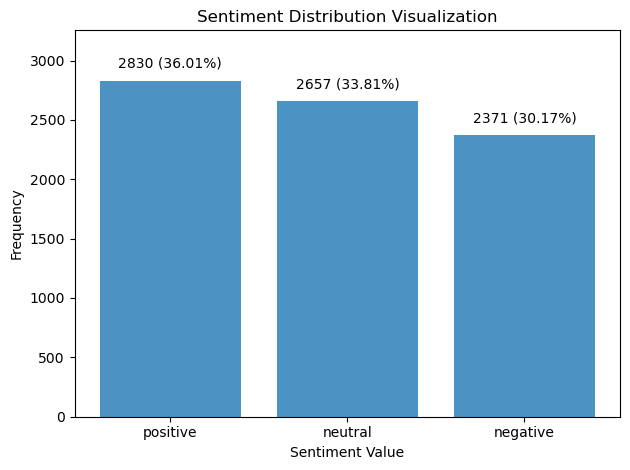

In [48]:
# Calculate and visualize the distribution of sentiment values in the DataFrame using a bar chart.
# Each bar is labelled with the sentiment count and its relative percentage.

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = processed_df['Sentiment'].value_counts()
sentiment_ratio = processed_df['Sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

In [18]:
processed_df

,Headlines,Sentiment
0,spicejet to issue 64 crore warrants to promoters,neutral
1,mmtc q2 net loss at rs 104 crore,neutral
2,midcap funds can deliver more stay put experts,positive
3,mid caps now turn into market darlings,positive
4,market seeing patience if not conviction praka...,neutral
...,...,...
10697,vedantacairn deal may not go through ajay bagga,negative
10700,wall street opens flat sp 500 near record,neutral
10710,heard on the street dutchman mf fiis,neutral
10714,rebound for russia and china lifts stocks,positive


### Implementation of LSTM and it's variants

In [52]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250

def tokenize_and_pad(data):
    """
    Tokenizes and pads input data sequences.
    
    Args:
        data (list): A list of text data to be tokenized and padded.
    
    Returns:
        ndarray: Tokenized and padded data.
    """
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(data)
    sequences = tokenizer.texts_to_sequences(data)
    return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH),tokenizer

In [41]:
def split_data(X, Y, test_size=0.3, val_split=0.5):
    """
    Splits data into training, validation, and testing sets.
    
    Args:
        X (ndarray): Features data.
        Y (ndarray): Labels data.
        test_size (float): Proportion of test data.
        val_split (float): Proportion of validation data from test data.
    
    Returns:
        tuple: Training, validation, and test sets for features and labels.
    """
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=test_size, random_state=5)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=val_split, random_state=5)
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [49]:
def plot_training_history(history):
    """
    Plot training & validation accuracy and loss.
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

def plot_confusion_matrix(Y_true, Y_pred_classes):
    """
    Plot the confusion matrix using Seaborn.
    """
    conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def print_misclassified_sentences(Y_true, Y_pred_classes, X_data_indices, processed_df):
    """
    Print misclassified sentences using original DataFrame.
    """
    misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
    for idx in misclassified_idx:
        true_label = Y_true[idx]
        pred_label = Y_pred_classes[idx]
        original_text = processed_df.iloc[X_data_indices[idx]]['Headlines']
        print(f"Original label: {true_label} - Predicted: {pred_label} - Text: {original_text}")


In [4]:
def compute_FPR_spec_metrics(cm, labels=["negative", "neutral" , "positive"]):
    """
    Compute specificity, FPR, precision for each class, and the overall accuracy given a 3x3 confusion matrix.
    Also, computes weighted and macro average for FPR and specificity.

    Args:
    - cm (numpy array): 3x3 confusion matrix
    - labels (list): List of class labels in order

    Returns:
    None. It will print the results directly.
    """
    
    specificities = []
    fprs = []
    precisions = []

    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        fn = sum(cm[i, j] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        
        specificities.append(round(specificity, 4))
        fprs.append(round(fpr, 4))
        precisions.append(round(precision, 4))
    
    # Print the class values with their corresponding metrics
    for i, label in enumerate(labels):
        print(f"Metrics for class {label} (Class value: {i}):")
        print(f"Specificity: {specificities[i]}")
        print(f"FPR: {fprs[i]}")
        print(f"Precision: {precisions[i]}\n")

    # Calculate overall accuracy
    accuracy = round(np.trace(cm) / np.sum(cm), 4)
    print(f"Overall accuracy: {accuracy}")

    # Calculate true values for each class for weighting purposes
    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)

    # Calculate weighted average specificity and FPR
    weighted_avg_spec = round(sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values, 4)
    weighted_avg_fpr = round(sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values, 4)

    # Calculate macro average specificity and FPR
    macro_avg_spec = round(np.mean(specificities), 4)
    macro_avg_fpr = round(np.mean(fprs), 4)

    print(f"Weighted average specificity: {weighted_avg_spec}")
    print(f"Weighted average FPR: {weighted_avg_fpr}")
    print(f"Macro average specificity: {macro_avg_spec}")
    print(f"Macro average FPR: {macro_avg_fpr}\n")


In [ ]:
def misclassification_report(model, X_test, Y_test, tokenizer, n_samples):
    """
    Generates a report on the misclassified samples from a test dataset based on the model's predictions.

    This function decodes tokenized sequences from a test dataset to original sentences,
    identifies the sentences that were misclassified by the model, and then prints them along with
    their true and predicted labels.

    Parameters:
    - model: A trained machine learning model used for predictions.
    - X_test: A sequence of tokenized sentences representing the test dataset.
    - Y_test: The true labels of the test dataset.
    - tokenizer: Tokenizer object used to tokenize the text data. Should have a `word_index` attribute.
    - n_samples: Integer indicating the number of misclassified samples to display in the report.

    Returns:
    None. The function prints out misclassified samples directly.
    """
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

    def sequence_to_text(sequence):
        return ' '.join([reverse_word_map.get(word, '?') for word in sequence if word != 0])  # 0 is padding

    test_pred = model.predict(X_test)
    test_pred = np.argmax(test_pred, axis=-1)
    Y_test_argmax = np.argmax(Y_test, axis=-1)

    misclassified_indices = np.where(test_pred != Y_test_argmax)[0]

    # Get the first n_samples misclassified indices, sentences, true labels, and predicted labels
    misclassified_sentences = [sequence_to_text(X_test[i]) for i in misclassified_indices[:n_samples]]
    true_labels = [Y_test_argmax[i] for i in misclassified_indices[:n_samples]]
    misclassified_labels = [test_pred[i] for i in misclassified_indices[:n_samples]]

    label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

    # Print the first n_samples misclassified sentences along with their true and predicted labels
    for idx, (sentence, true_label, pred_label) in enumerate(zip(misclassified_sentences, true_labels, misclassified_labels)):
        print(f"{idx + 1}. {sentence}")
        print(f"   True Sentiment: {label_map[true_label]}")
        print(f"   Misclassified as: {label_map[pred_label]}\n")

### The Implementation of standard LSTM Model(batch size-32,64 and 128)

In [42]:
def build_model(hp, max_nb_words=MAX_NB_WORDS, input_length=MAX_SEQUENCE_LENGTH):
    """
    Builds a LSTM model for sentiment analysis.
    
    Args:
        hp (HyperParameters): Hyperparameters for the model.
        max_nb_words (int): Maximum number of words for the Embedding layer.
        input_length (int): Input length for the Embedding layer.
    
    Returns:
        Model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(max_nb_words, hp.Int('embedding_dim', min_value=32, max_value=512, step=32), input_length=input_length))
    model.add(SpatialDropout1D(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(LSTM(hp.Int('lstm_units', min_value=32, max_value=512, step=32), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [43]:
def run_tuner(batch_size, X_train, Y_train, X_val, Y_val, project_name):
    """
    Runs the Keras tuner for hyperparameter optimization.
    
    Args:
        batch_size (int): Batch size for training.
        X_train (ndarray): Training features.
        Y_train (ndarray): Training labels.
        X_val (ndarray): Validation features.
        Y_val (ndarray): Validation labels.
        project_name (str): Name of the tuning project.
    """
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name)
    
    tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val), batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

In [53]:
X,tokenizer = tokenize_and_pad(processed_df['Headlines'].values)# Tokenizer used here is for the misclassification report
Y = pd.get_dummies(processed_df['Sentiment']).values

X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

run_tuner(32, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_32')
run_tuner(64, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_64')
run_tuner(128, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_128')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_32/tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_64/tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_128/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [45]:
#helps reloading the project after it has been tuned.
def tuner_reload(project_name):
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name
    )
    tuner.reload()
    print(f"Hyperparameter values for {project_name}")    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print_hyperparameters(best_hps)

    best_model = tuner.get_best_models(num_models=1)[0]
    print_model_summary(best_model)

    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    
    # Modify the metric retrieval line
    best_val_accuracy = best_trial.metrics.metrics['val_accuracy'].get_best_value()
    print(f"Best validation accuracy: {best_val_accuracy}")

In [46]:
tuner_reload('SentimentAnalysis_32')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_32/tuner0.json
Hyperparameter values for SentimentAnalysis_32

    The hyperparameters :. 
    LSTM Units: 160
    Dropout Rate: 0.4
    Embedding Dimension: 96
    
Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 96)           4800000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 96)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 160)               164480    
                                                                 
 dense (Dense)               (None, 3)                 483       
                                                                 
Total

In [47]:
tuner_reload('SentimentAnalysis_64')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_64/tuner0.json
Hyperparameter values for SentimentAnalysis_64

    The hyperparameters :. 
    LSTM Units: 32
    Dropout Rate: 0.4
    Embedding Dimension: 64
    
Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           3200000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 64)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total 

In [48]:
tuner_reload('SentimentAnalysis_128')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_128/tuner0.json
Hyperparameter values for SentimentAnalysis_128

    The hyperparameters :. 
    LSTM Units: 96
    Dropout Rate: 0.4
    Embedding Dimension: 288
    
Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 288)          14400000  
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 288)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 96)                147840    
                                                                 
 dense (Dense)               (None, 3)                 291       
                                                                 
Tot

#### The best results were obtained by 64 batch size and the batch size 64 will remian constant in the implementation of the LSTM variants

Epoch 1/10
86/86 [==============================] - 11s 117ms/step - loss: 1.0432 - accuracy: 0.4578 - val_loss: 0.9054 - val_accuracy: 0.6158
Epoch 2/10
86/86 [==============================] - 10s 116ms/step - loss: 0.7001 - accuracy: 0.7431 - val_loss: 0.6459 - val_accuracy: 0.7464
Epoch 3/10
86/86 [==============================] - 10s 114ms/step - loss: 0.3855 - accuracy: 0.8665 - val_loss: 0.5582 - val_accuracy: 0.7829
Epoch 4/10
86/86 [==============================] - 10s 116ms/step - loss: 0.2451 - accuracy: 0.9173 - val_loss: 0.5716 - val_accuracy: 0.7880
Epoch 5/10
86/86 [==============================] - 10s 114ms/step - loss: 0.1632 - accuracy: 0.9507 - val_loss: 0.6051 - val_accuracy: 0.7820
Epoch 6/10
37/37 [==============================] - 0s 9ms/step


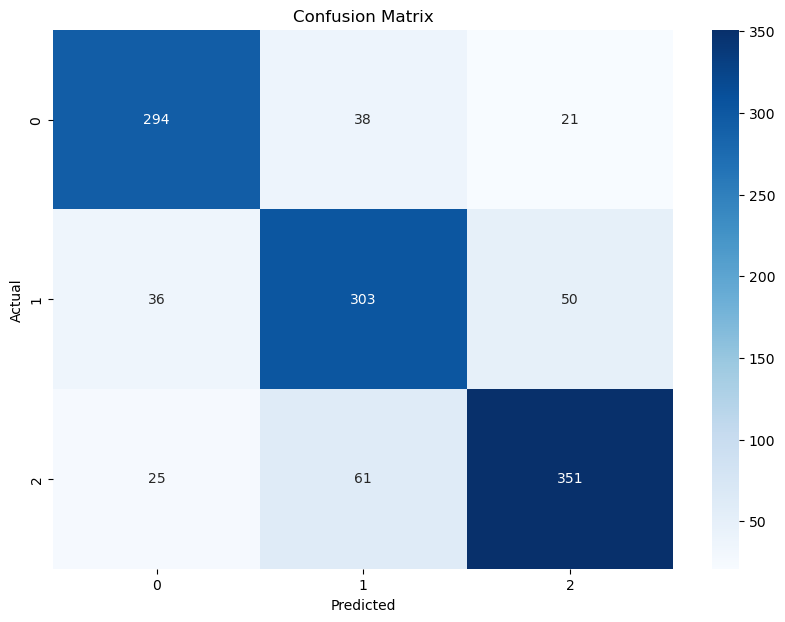

              precision    recall  f1-score   support

    Negative     0.8282    0.8329    0.8305       353
     Neutral     0.7537    0.7789    0.7661       389
    Positive     0.8318    0.8032    0.8172       437

    accuracy                         0.8041      1179
   macro avg     0.8046    0.8050    0.8046      1179
weighted avg     0.8049    0.8041    0.8043      1179



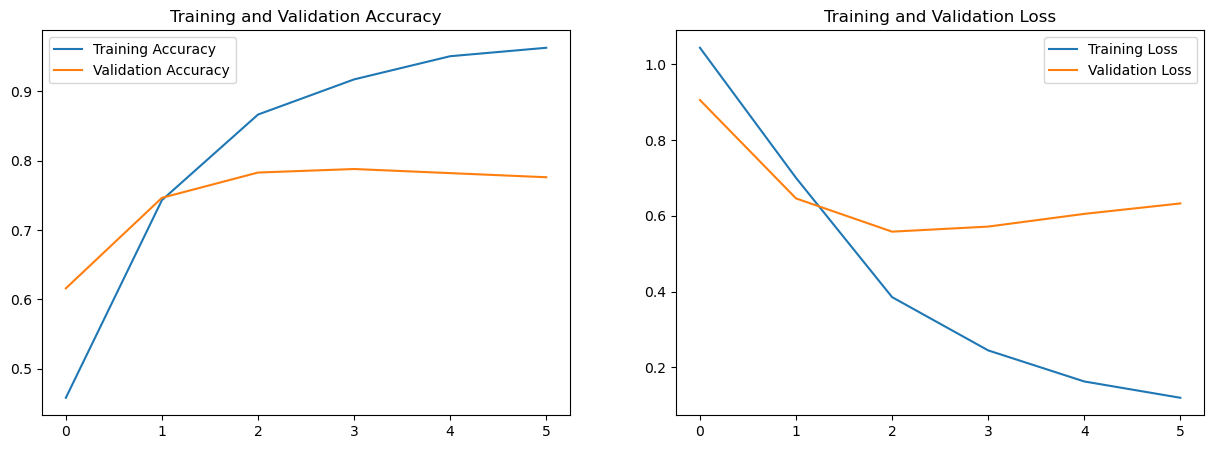

In [103]:
#implementing the standard LSTM with the best parameters
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 64, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=-1)
Y_test_argmax = np.argmax(Y_test, axis=-1)

plot_confusion_matrix(Y_test_argmax, test_pred)
print(classification_report(Y_test_argmax, test_pred, target_names=['Negative', 'Neutral', 'Positive'],digits=4))

plot_training_history(history)

In [5]:
#need to enter the values to the matrix manually as this can change based on the fine tuning of the model
cm = np.array([[294, 38, 21], 
               [36, 303, 50], 
               [25, 61, 351]])

compute_FPR_spec_metrics(cm)

Metrics for class negative (Class value: 0):
Specificity: 0.9147
FPR: 0.0853
Precision: 0.8282

Metrics for class neutral (Class value: 1):
Specificity: 0.8669
FPR: 0.1331
Precision: 0.7537

Metrics for class positive (Class value: 2):
Specificity: 0.8937
FPR: 0.1063
Precision: 0.8318

Overall accuracy: 0.8041
Weighted average specificity: 0.8911
Weighted average FPR: 0.1089
Macro average specificity: 0.8918
Macro average FPR: 0.1082



In [104]:
misclassification_report(model, X_test, Y_test, tokenizer, n_samples=10)

37/37 [==============================] - 0s 9ms/step
1. expect maruti stocks to hold up with upcoming product launches pramod gubbi
   True Sentiment: Positive
   Misclassified as: Neutral

2. gold steady below 3week top fed meeting eyed
   True Sentiment: Negative
   Misclassified as: Neutral

3. avoid bank stocks prateek agarwal ask investment managers
   True Sentiment: Negative
   Misclassified as: Neutral

4. fii buying in vmart retail crosses limit no further purchase
   True Sentiment: Negative
   Misclassified as: Neutral

5. sustained call writing at strike price 8300 on nifty50 keeping bulls at bay
   True Sentiment: Negative
   Misclassified as: Positive

6. mindtree on course to join 1bn revenue club in next 5 years but present valuations fairly rich girish pai
   True Sentiment: Positive
   Misclassified as: Negative

7. strong deals crucial for wipros growth push
   True Sentiment: Neutral
   Misclassified as: Positive

8. tcs signals slowdown brokerages remain unfazed re

In [105]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 64)           3200000   
                                                                 
 spatial_dropout1d_4 (Spati  (None, 250, 64)           0         
 alDropout1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 3212515 (12.25 MB)
Trainable params: 3212515 (12.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Stacked LSTM

In [70]:
def build_stacked_model(hp, max_nb_words=MAX_NB_WORDS, input_length=MAX_SEQUENCE_LENGTH):
    """
    Builds a stacked LSTM model for sentiment analysis.
    
    Args:
        hp (HyperParameters): Hyperparameters for the model.
        max_nb_words (int): Maximum number of words for the Embedding layer.
        input_length (int): Input length for the Embedding layer.
    
    Returns:
        Model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(max_nb_words, hp.Int('embedding_dim', min_value=32, max_value=512, step=32), input_length=input_length))
    model.add(SpatialDropout1D(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(LSTM(hp.Int('lstm_units_1', min_value=32, max_value=512, step=32), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(hp.Int('lstm_units_2', min_value=32, max_value=512, step=32), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [83]:
def run_stacked_tuner(batch_size, X_train, Y_train, X_val, Y_val, project_name):
    """
    Runs the Keras tuner for hyperparameter optimization of the stacked LSTM model.
    
    Args:
        batch_size (int): Batch size for training.
        X_train (ndarray): Training features.
        Y_train (ndarray): Training labels.
        X_val (ndarray): Validation features.
        Y_val (ndarray): Validation labels.
        project_name (str): Name of the tuning project.
    """
    tuner = RandomSearch(
        build_stacked_model,  # note the change in the function name here
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name)
    
    tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val), batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


In [87]:
#helps reload the project for the fine tuned model
def tuner_reload_s(project_name):
    tuner = RandomSearch(
        build_stacked_model,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name
    )
    tuner.reload()
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    
    best_val_accuracy = best_trial.metrics.metrics['val_accuracy'].get_best_value()
    
    print(f"""
    The hyperparameters search is complete. 
    The optimal number of units in the first LSTM layer is {best_hps_s.get('lstm_units_1')} 
    and the optimal number of units in the second LSTM layer is {best_hps_s.get('lstm_units_2')}.
    The optimal dropout rate is {best_hps_s.get('dropout_rate')}. 
    The optimal embedding dimension is {best_hps_s.get('embedding_dim')}.
    """)

    print(f"Best validation accuracy: {best_val_accuracy}")

    # Print best hyperparameters
    print("Best Hyperparameters:")
    print(best_hps_s.values)

    # Print best model summary
    print("Best Model Summary:")
    best_model_s.summary()

In [73]:
run_stacked_tuner(64, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_stacked')

Trial 20 Complete [00h 30m 17s]
val_accuracy: 0.7718405425548553

Best val_accuracy So Far: 0.7811704874038696
Total elapsed time: 10h 57m 18s
INFO:tensorflow:Oracle triggered exit


In [88]:
# Reload the tuner and get the best hyperparameters, model, and validation accuracy.
tuner_reload_s('SentimentAnalysis_stacked')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_stacked/tuner0.json

    The hyperparameters search is complete. 
    The optimal number of units in the first LSTM layer is 256 
    and the optimal number of units in the second LSTM layer is 256.
    The optimal dropout rate is 0.35000000000000003. 
    The optimal embedding dimension is 352.
    
Best validation accuracy: 0.7811704874038696
Best Hyperparameters:
{'embedding_dim': 352, 'dropout_rate': 0.35000000000000003, 'lstm_units_1': 256, 'lstm_units_2': 256}
Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 352)          17600000  
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 352)          0         
 Dropout1D)                                                      
                              

Epoch 1/10
86/86 [==============================] - 214s 2s/step - loss: 0.8305 - accuracy: 0.6100 - val_loss: 0.5975 - val_accuracy: 0.7600
Epoch 2/10
86/86 [==============================] - 212s 2s/step - loss: 0.3553 - accuracy: 0.8713 - val_loss: 0.5868 - val_accuracy: 0.7642
Epoch 3/10
86/86 [==============================] - 214s 2s/step - loss: 0.1833 - accuracy: 0.9373 - val_loss: 0.6729 - val_accuracy: 0.7557
Epoch 4/10
86/86 [==============================] - 215s 3s/step - loss: 0.0954 - accuracy: 0.9698 - val_loss: 0.8341 - val_accuracy: 0.7634
Epoch 5/10
37/37 [==============================] - 14s 389ms/step


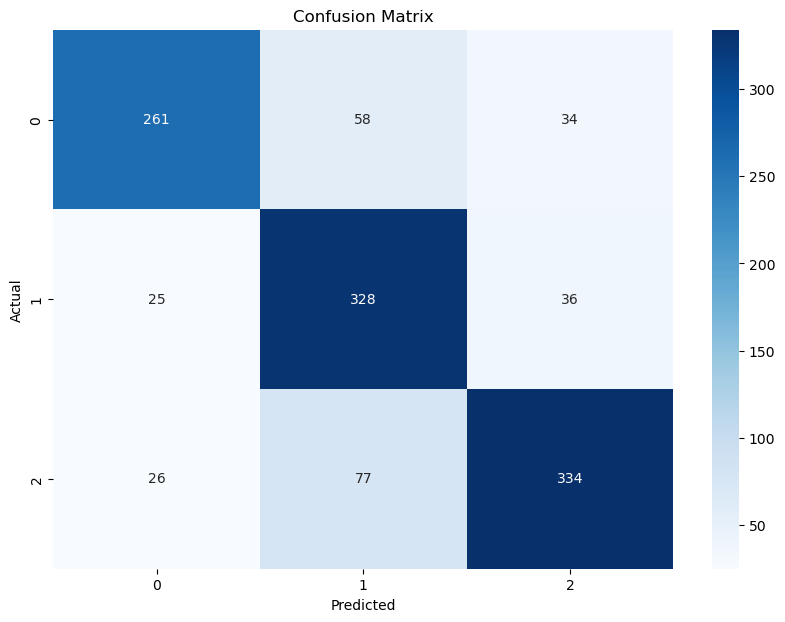

              precision    recall  f1-score   support

    Negative     0.8365    0.7394    0.7850       353
     Neutral     0.7084    0.8432    0.7700       389
    Positive     0.8267    0.7643    0.7943       437

    accuracy                         0.7829      1179
   macro avg     0.7906    0.7823    0.7831      1179
weighted avg     0.7906    0.7829    0.7835      1179



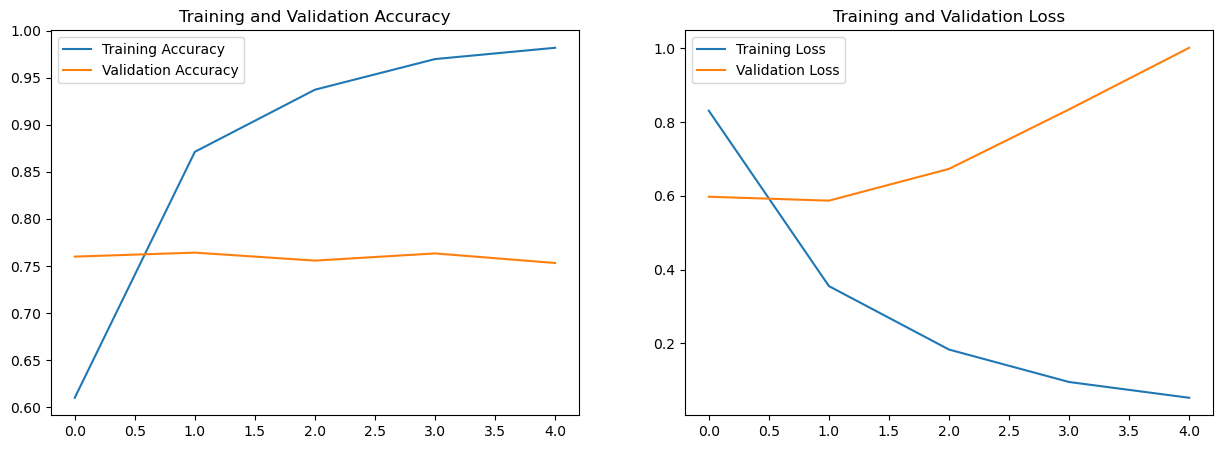

In [99]:
#Training the stacked LSTM with the best parameters after tuning
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 352, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.35000000000000003))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=-1)
Y_test_argmax = np.argmax(Y_test, axis=-1)

plot_confusion_matrix(Y_test_argmax, test_pred)
print(classification_report(Y_test_argmax, test_pred, target_names=['Negative', 'Neutral', 'Positive'],digits=4))

plot_training_history(history)

In [5]:
#need to enter the values to the matrix manually as this can change based on the fine tuning of the model
cm = np.array([[261, 58, 34], 
               [25, 328, 36], 
               [26, 77, 334]])

compute_FPR_spec_metrics(cm)

Metrics for class negative (Class value: 0):
Specificity: 0.9285
FPR: 0.0715
Precision: 0.8365

Metrics for class neutral (Class value: 1):
Specificity: 0.8151
FPR: 0.1849
Precision: 0.7084

Metrics for class positive (Class value: 2):
Specificity: 0.8938
FPR: 0.1062
Precision: 0.8267

Overall accuracy: 0.7829
Weighted average specificity: 0.8782
Weighted average FPR: 0.1218
Macro average specificity: 0.8791
Macro average FPR: 0.1209



In [100]:
misclassification_report(model, X_test, Y_test, tokenizer, n_samples=10)

37/37 [==============================] - 15s 394ms/step
1. gold trades near 4month low before european central bank decision us data
   True Sentiment: Negative
   Misclassified as: Positive

2. china shares post biggest daily loss in six months on economy liquidity worries
   True Sentiment: Negative
   Misclassified as: Positive

3. expect maruti stocks to hold up with upcoming product launches pramod gubbi
   True Sentiment: Positive
   Misclassified as: Neutral

4. gold steady below 3week top fed meeting eyed
   True Sentiment: Negative
   Misclassified as: Neutral

5. as copper runs low producers turn ideas to boost output of metal
   True Sentiment: Negative
   Misclassified as: Positive

6. unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
   True Sentiment: Negative
   Misclassified as: Neutral

7. avoid bank stocks prateek agarwal ask investment managers
   True Sentiment: Negative
   Misclassified as: Neutral

8. fii buying in vmart retail crosses limit no furthe

In [101]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 352)          17600000  
                                                                 
 spatial_dropout1d_2 (Spati  (None, 250, 352)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 250, 256)          623616    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 18749699 (71.52 MB)
Trainable params: 18749699 (71.52 MB)
Non-trainable params: 0 (0.00 Byte)
____________

### Bi-Directional LSTM

In [89]:
def build_bidirectional_model(hp, max_nb_words=MAX_NB_WORDS, input_length=MAX_SEQUENCE_LENGTH):
    """
    Builds a Bidirectional LSTM model for sentiment analysis.
    
    Args:
        hp (HyperParameters): Hyperparameters for the model.
        max_nb_words (int): Maximum number of words for the Embedding layer.
        input_length (int): Input length for the Embedding layer.
    
    Returns:
        Model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(max_nb_words, hp.Int('embedding_dim', min_value=32, max_value=512, step=32), input_length=input_length))
    model.add(SpatialDropout1D(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=512, step=32), dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [90]:
def run_bidirectional_tuner(batch_size, X_train, Y_train, X_val, Y_val, project_name):
    """
    Runs the Keras tuner for hyperparameter optimization of the Bidirectional LSTM model.
    
    Args:
        batch_size (int): Batch size for training.
        X_train (ndarray): Training features.
        Y_train (ndarray): Training labels.
        X_val (ndarray): Validation features.
        Y_val (ndarray): Validation labels.
        project_name (str): Name of the tuning project.
    """
    tuner = RandomSearch(
        build_bidirectional_model,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name)
    
    tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val), batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


In [91]:
#Helps reload the fine tuned parameters
def tuner_reload_bi(project_name):
    tuner = RandomSearch(
        build_bidirectional_model,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name
    )
    tuner.reload()
    print(f"Hyperparameter values for {project_name}")    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print_hyperparameters(best_hps)

    best_model = tuner.get_best_models(num_models=1)[0]
    print_model_summary(best_model)

    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    
    # Modify the metric retrieval line
    best_val_accuracy = best_trial.metrics.metrics['val_accuracy'].get_best_value()
    print(f"Best validation accuracy: {best_val_accuracy}")

In [92]:
run_bidirectional_tuner(64, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_bidirectional')

Trial 20 Complete [00h 43m 58s]
val_accuracy: 0.7866836190223694

Best val_accuracy So Far: 0.7921967506408691
Total elapsed time: 11h 20m 43s
INFO:tensorflow:Oracle triggered exit


In [93]:
tuner_reload_bi('SentimentAnalysis_bidirectional')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_bidirectional/tuner0.json
Hyperparameter values for SentimentAnalysis_bidirectional

    The hyperparameters :. 
    LSTM Units: 512
    Dropout Rate: 0.0
    Embedding Dimension: 384
    
Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 384)          19200000  
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 384)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 1024)              3674112   
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)          

Epoch 1/10
86/86 [==============================] - 369s 4s/step - loss: 1.0189 - accuracy: 0.5625 - val_loss: 0.6453 - val_accuracy: 0.7277
Epoch 2/10
86/86 [==============================] - 366s 4s/step - loss: 0.3623 - accuracy: 0.8653 - val_loss: 0.5615 - val_accuracy: 0.7812
Epoch 3/10
86/86 [==============================] - 365s 4s/step - loss: 0.1493 - accuracy: 0.9518 - val_loss: 0.6198 - val_accuracy: 0.7769
Epoch 4/10
86/86 [==============================] - 372s 4s/step - loss: 0.0695 - accuracy: 0.9784 - val_loss: 0.8152 - val_accuracy: 0.7625
Epoch 5/10
37/37 [==============================] - 40s 1s/step


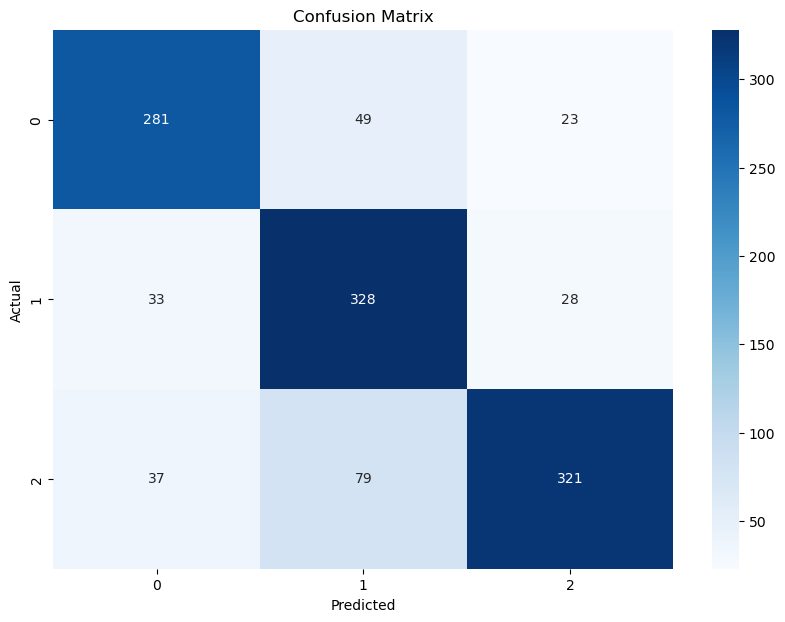

              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80       353
     Neutral       0.72      0.84      0.78       389
    Positive       0.86      0.73      0.79       437

    accuracy                           0.79      1179
   macro avg       0.79      0.79      0.79      1179
weighted avg       0.80      0.79      0.79      1179



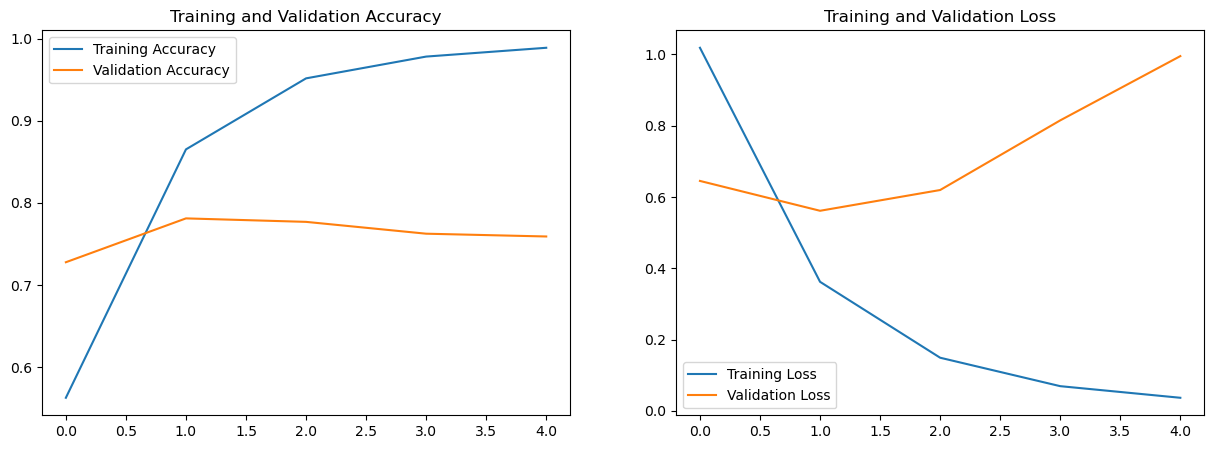

In [94]:
#implementing BiLSTM with the best parameters from the study
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 384, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.0))
model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=-1)
Y_test_argmax = np.argmax(Y_test, axis=-1)

plot_confusion_matrix(Y_test_argmax, test_pred)
print(classification_report(Y_test_argmax, test_pred, target_names=['Negative', 'Neutral', 'Positive'], digits=4))

plot_training_history(history)

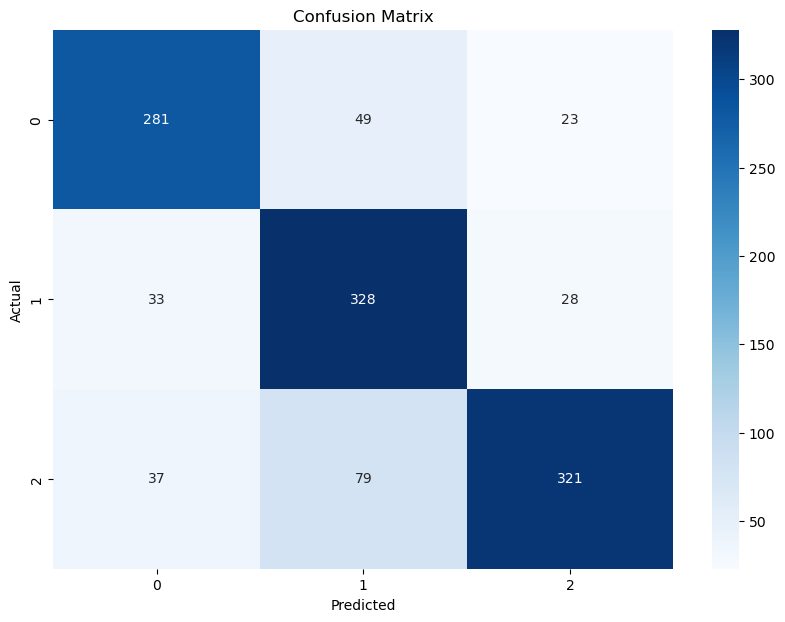

              precision    recall  f1-score   support

    Negative     0.8006    0.7960    0.7983       353
     Neutral     0.7193    0.8432    0.7763       389
    Positive     0.8629    0.7346    0.7936       437

    accuracy                         0.7888      1179
   macro avg     0.7943    0.7913    0.7894      1179
weighted avg     0.7969    0.7888    0.7893      1179



In [98]:
plot_confusion_matrix(Y_test_argmax, test_pred)
print(classification_report(Y_test_argmax, test_pred, target_names=['Negative', 'Neutral', 'Positive'],digits=4))

In [6]:
#need to enter the values to the matrix manually as this can change based on the fine tuning of the model
cm = np.array([[281, 49, 23], 
               [33, 328, 28], 
               [37, 79, 321]])

compute_FPR_spec_metrics(cm)

Metrics for class negative (Class value: 0):
Specificity: 0.9026
FPR: 0.0974
Precision: 0.8006

Metrics for class neutral (Class value: 1):
Specificity: 0.8247
FPR: 0.1753
Precision: 0.7193

Metrics for class positive (Class value: 2):
Specificity: 0.9227
FPR: 0.0773
Precision: 0.8629

Overall accuracy: 0.7888
Weighted average specificity: 0.8843
Weighted average FPR: 0.1157
Macro average specificity: 0.8833
Macro average FPR: 0.1167



In [95]:
misclassification_report(model, X_test, Y_test, tokenizer, n_samples=10)

37/37 [==============================] - 41s 1s/step
1. gold trades near 4month low before european central bank decision us data
   True Sentiment: Negative
   Misclassified as: Neutral

2. china shares post biggest daily loss in six months on economy liquidity worries
   True Sentiment: Negative
   Misclassified as: Positive

3. expect maruti stocks to hold up with upcoming product launches pramod gubbi
   True Sentiment: Positive
   Misclassified as: Neutral

4. gold steady below 3week top fed meeting eyed
   True Sentiment: Negative
   Misclassified as: Neutral

5. as copper runs low producers turn ideas to boost output of metal
   True Sentiment: Negative
   Misclassified as: Positive

6. avoid bank stocks prateek agarwal ask investment managers
   True Sentiment: Negative
   Misclassified as: Neutral

7. fii buying in vmart retail crosses limit no further purchase
   True Sentiment: Negative
   Misclassified as: Neutral

8. sustained call writing at strike price 8300 on nifty50 k

In [96]:
model

In [97]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 384)          19200000  
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 384)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 1024)              3674112   
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 22877187 (87.27 MB)
Trainable params: 22877187 (87.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)